In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras



# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os,shutil


seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
import datetime, os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import Sequential,Model,load_model
from keras.applications.resnet50 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import preprocess_input

In [2]:
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()
  #plt.show()



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
meta= pd.read_csv(r"/content/drive/MyDrive/musicnet_metadata.csv")

In [5]:
composers=meta["composer"].unique()

In [6]:
path=os.getcwd()
val_path = "/content/drive/MyDrive/splitted/val"
train_path = "/content/drive/MyDrive/splitted/train"

In [7]:
image_generator =  ImageDataGenerator(preprocessing_function= tf.keras.applications.inception_v3.preprocess_input) 
train_dataset = image_generator.flow_from_directory(batch_size= 25, directory=train_path, classes=list(composers),shuffle=True)
validation_dataset = image_generator.flow_from_directory(batch_size=1,directory=val_path, classes=list(composers),shuffle = False)
                                          
                                                 

Found 3398 images belonging to 10 classes.
Found 424 images belonging to 10 classes.


In [8]:
num_classes = 10

input_shape=(256, 256, 3)
validation_dataset.next()[0].shape

(1, 256, 256, 3)

In [9]:

base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(256,256,3))


87916544/87910968 [==============================] - 1s 0us/step


In [10]:
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.3)

flattened = keras.layers.Flatten()(base_model.output)

drop1 = dropout1(flattened)
flattened = keras.layers.Dense(512, activation='relu')(drop1)

drop2 = dropout2(flattened)
flattened = keras.layers.Dense(256, activation='relu')(drop2)

predictions = Dense(num_classes, activation = 'softmax')(flattened)
model = Model(inputs = base_model.input, outputs = predictions)

In [11]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:


adam = Adam(lr=0.0001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()




In [14]:
epochs = 40
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,min_delta=0.0001)

In [ ]:
fft3 = model.fit(train_dataset,
    validation_data = validation_dataset,  
    epochs = epochs, workers = 10, 
    callbacks =[lr_callback, stopping_callback], shuffle=True)

In [ ]:
print("Train loss", fft3.history["loss"][-1])
print("Train accuracy",  fft3.history["accuracy"][-1])

print("Val loss", fft3.history["val_loss"][-1])
print("Val accuracy",  fft3.history["val_accuracy"][-1])

In [ ]:
plot_history(fft3)

In [ ]:
Y_pred = model.predict(validation_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

In [ ]:
y_true = validation_dataset.classes
y_true

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    #num_classes = 10
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names_val, rotation=45)
    plt.yticks(tick_marks, class_names_val)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
class_names_val = ['Schubert','Mozart','Dvorak','Cambini','Haydn','Brahms','Faure', 'Ravel','Bach','Beethoven']


Confusion matrix, without normalization


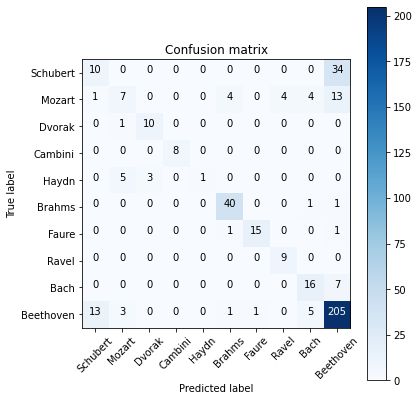

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes = [0,1,2,3,4,5,6,7,8,9])

In [ ]:
model.save("/content/drive/MyDrive/inception_v3_model3_fft.h5")